In [15]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드.
feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                           header=None,names=['column_index','column_name'])
                           
# 피처명 index를 제거하고, 피처명만 리스트 객체로 생성한 뒤 샘플로 10개만 추출\n,
feature_name = feature_name_df.iloc[:, 1].values.tolist()
print('전체 피처명에서 10개만 추출:', feature_name[:10])

전체 피처명에서 10개만 추출: ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [22]:
feature_dup_df = feature_name_df.groupby('column_name').count()
print(feature_dup_df[feature_dup_df['column_index'] > 1].count())
feature_dup_df[feature_dup_df['column_index'] > 1].head()

column_index    42
dtype: int64


,column_index
column_name,
"fBodyAcc-bandsEnergy()-1,16",3
"fBodyAcc-bandsEnergy()-1,24",3
"fBodyAcc-bandsEnergy()-1,8",3
"fBodyAcc-bandsEnergy()-17,24",3
"fBodyAcc-bandsEnergy()-17,32",3


In [24]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                                if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [25]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\\s+',
                                    header=None,names=['column_index','column_name'])
    
    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
        
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
       
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용,
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\\s+', names=feature_name)
       
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\\s+',header=None,names=['action'])
        
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test
    
X_train, X_test, y_train, y_test = get_human_dataset()

In [28]:
print('## 학습 피처 데이터셋 info()')
print()
print(X_train.info())
print()
print(y_train['action'].value_counts())

## 학습 피처 데이터셋 info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None

action
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
    
# 예제 반복 시 마다 동일한 예측 결과 도출을 위해 random_state 설정
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train , y_train)
pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('결정 트리 예측 정확도: {0:.4f}'.format(accuracy))
    
# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터:\\n', dt_clf.get_params())

결정 트리 예측 정확도: 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터:\n {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 156, 'splitter': 'best'}


In [30]:
from sklearn.model_selection import GridSearchCV
    
params = {'max_depth' : [ 6, 8 ,10, 12, 16 ,20, 24]}
    
grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치:{0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
GridSearchCV 최고 평균 정확도 수치:0.8513
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 16}


In [31]:
# GridSearchCV객체의 cv_results_ 속성을 DataFrame으로 생성.
cv_results_df = pd.DataFrame(grid_cv.cv_results_)
    
# max_depth 파라미터 값과 그때의 테스트(Evaluation)셋, 학습 데이터 셋의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score']]

,param_max_depth,mean_test_score
0,6,0.851
1,8,0.851
2,10,0.851
3,12,0.844
4,16,0.851
5,20,0.851
6,24,0.849


In [32]:
max_depths = [ 6, 8 ,10, 12, 16 ,20, 24]
# max_depth 값을 변화 시키면서 그때마다 학습과 테스트 셋에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, min_samples_split=16, random_state=156)
    dt_clf.fit(X_train , y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test , pred)
    print('max_depth = {0} 정확도: {1:.4f}'.format(depth , accuracy))

max_depth = 6 정확도: 0.8551
max_depth = 8 정확도: 0.8717
max_depth = 10 정확도: 0.8599
max_depth = 12 정확도: 0.8571
max_depth = 16 정확도: 0.8599
max_depth = 20 정확도: 0.8565
max_depth = 24 정확도: 0.8565


In [33]:
params = {'max_depth' : [ 8 , 12, 16 ,20], 
        'min_samples_split' : [16, 24],}

grid_cv = GridSearchCV(dt_clf, param_grid=params, scoring='accuracy', cv=5, verbose=1 )
grid_cv.fit(X_train , y_train)
print('GridSearchCV 최고 평균 정확도 수치: {0:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터:', grid_cv.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
GridSearchCV 최고 평균 정확도 수치: 0.8549
GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 8, 'min_samples_split': 16}


In [34]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred1)
print('결정 트리 예측 정확도:{0:.4f}'.format(accuracy))

결정 트리 예측 정확도:0.8717


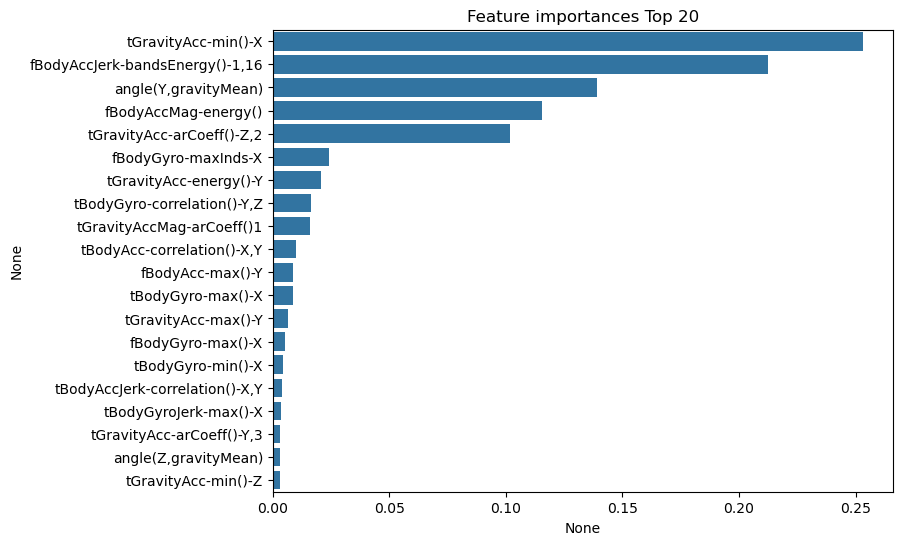

In [35]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게 하고, 시본(Seaborn)의 막대그래프로 쉽게 표현하기 위해 Series변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns  )
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()